In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

### Import datasets

In [2]:
#bulk fluorescence data
fluo = pd.read_csv('datasets/bulk-fluo-11.csv', index_col=0)
fluo.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,e16TerThyXS1,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
time,,,,,,,,,,,,,,,,,,,,,
0,21.62500,14.10682,-10.20240,-14.73152,33.51864,54.76527,30.03510,30.74070,76.93035,98.94185,101.80665,62.13312,17.90467,-6.91299,24.62000,76.44860,19.578000,-10.77699,24.425500,12.62616,31.97744
20,-101.37366,64.33200,63.38460,87.34615,175.67310,99.96154,89.73077,173.29753,127.39316,161.16140,140.73080,-129.68964,-137.81250,-85.89522,62.82879,126.96154,92.153847,109.12588,107.615385,156.70011,160.07416
40,-52.95490,-38.89568,-37.80715,-46.18264,-12.37340,-2.86740,-48.26601,-15.48820,-18.92473,20.74640,25.18580,-42.28900,-63.66528,-55.83582,-41.68976,-12.08031,-17.210700,-12.37340,-42.180800,13.03740,58.06452
60,-98.18847,-10.39050,23.09808,-15.46116,52.78819,24.15460,31.13992,42.37074,37.52530,56.37600,39.48879,-87.81814,-119.76525,-93.24080,-7.20240,47.33113,-13.380450,5.12220,27.694420,7.57491,61.09570
80,-53.51717,13.43900,6.63873,4.95120,42.97700,18.45877,25.04068,60.71615,64.04811,27.90936,56.60975,-61.15626,-95.25761,-49.29870,-0.86548,22.69449,7.170800,8.86480,-0.989730,33.28956,44.47770


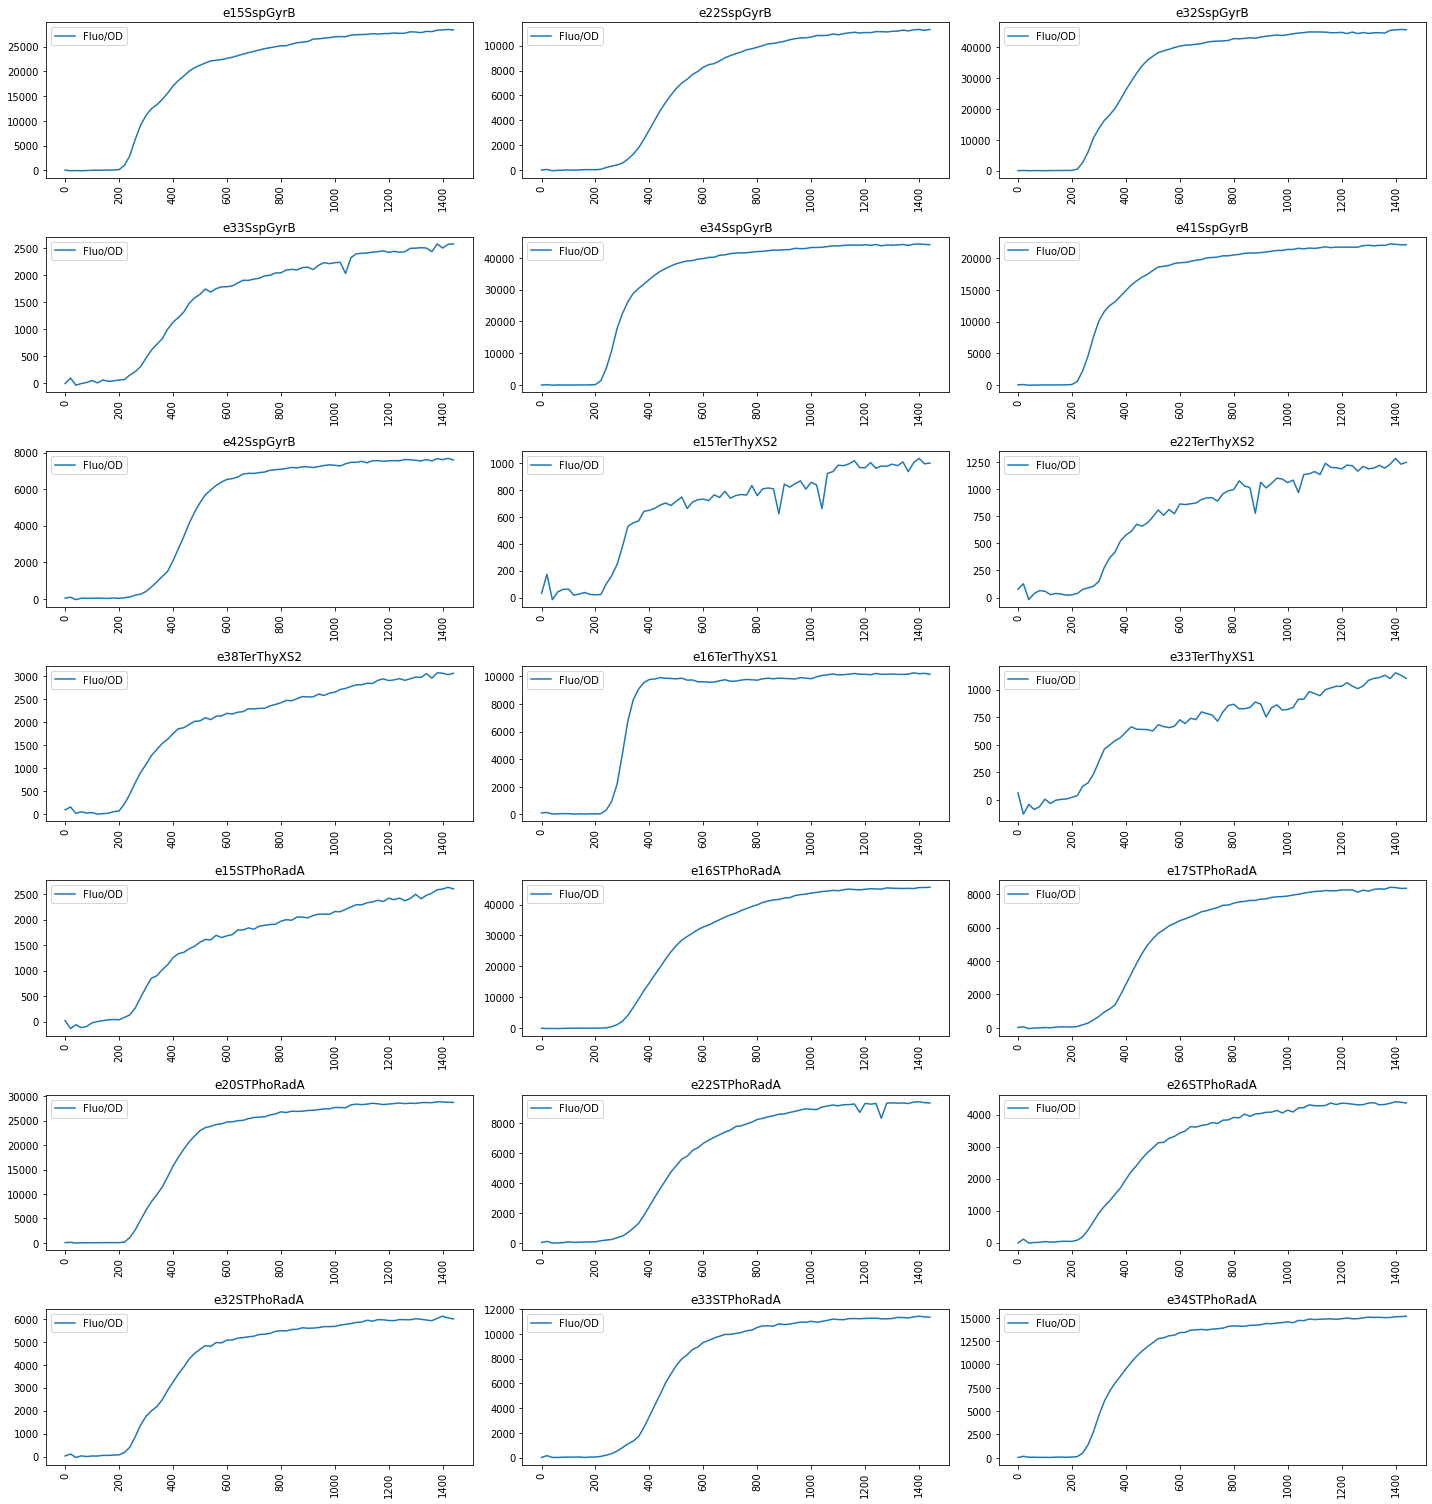

In [6]:
def plot_all(data, num_row, num_col):
    plt.figure(figsize=(20, num_row*3))
    for i in range(data.shape[1]):
        plt.subplot(num_row, num_col, i+1)
        data.iloc[:, i].plot(label='Fluo/OD')
        plt.legend()
        plt.title(data.columns[i])
        plt.xticks(rotation=90)
        plt.xlabel(None)
    plt.tight_layout()
    plt.show()
    
#plot bulk fluorescence data
plot_all(fluo, 7, 3)

In [3]:
#od only data
od = pd.read_csv('datasets/od-11.csv', index_col=0)
od.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,e16TerThyXS1,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
time,,,,,,,,,,,,,,,,,,,,,
0,0.025,0.026,0.040,0.032,0.024,0.0210,0.0300,0.010,0.015,-0.001,-0.005,0.002,0.007,0.021,0.020,0.0100,0.0200,0.021,0.0250,0.024,0.016
20,0.018,0.004,0.004,0.001,-0.006,-0.0004,-0.0002,-0.007,-0.004,-0.005,-0.008,0.018,0.021,0.017,0.003,-0.0004,0.0003,-0.002,-0.0001,-0.007,-0.008
40,0.019,0.016,0.017,0.014,0.010,0.0120,0.0130,0.007,0.011,0.008,0.004,0.013,0.018,0.017,0.014,0.0110,0.0130,0.010,0.0160,0.006,0.002
60,0.031,0.015,0.012,0.011,0.007,0.0100,0.0070,0.003,0.005,0.009,0.003,0.023,0.033,0.029,0.015,0.0110,0.0150,0.010,0.0130,0.007,0.002
80,0.037,0.020,0.021,0.016,0.011,0.0170,0.0140,0.005,0.007,0.018,0.005,0.022,0.037,0.033,0.022,0.0170,0.0260,0.016,0.0210,0.012,0.005


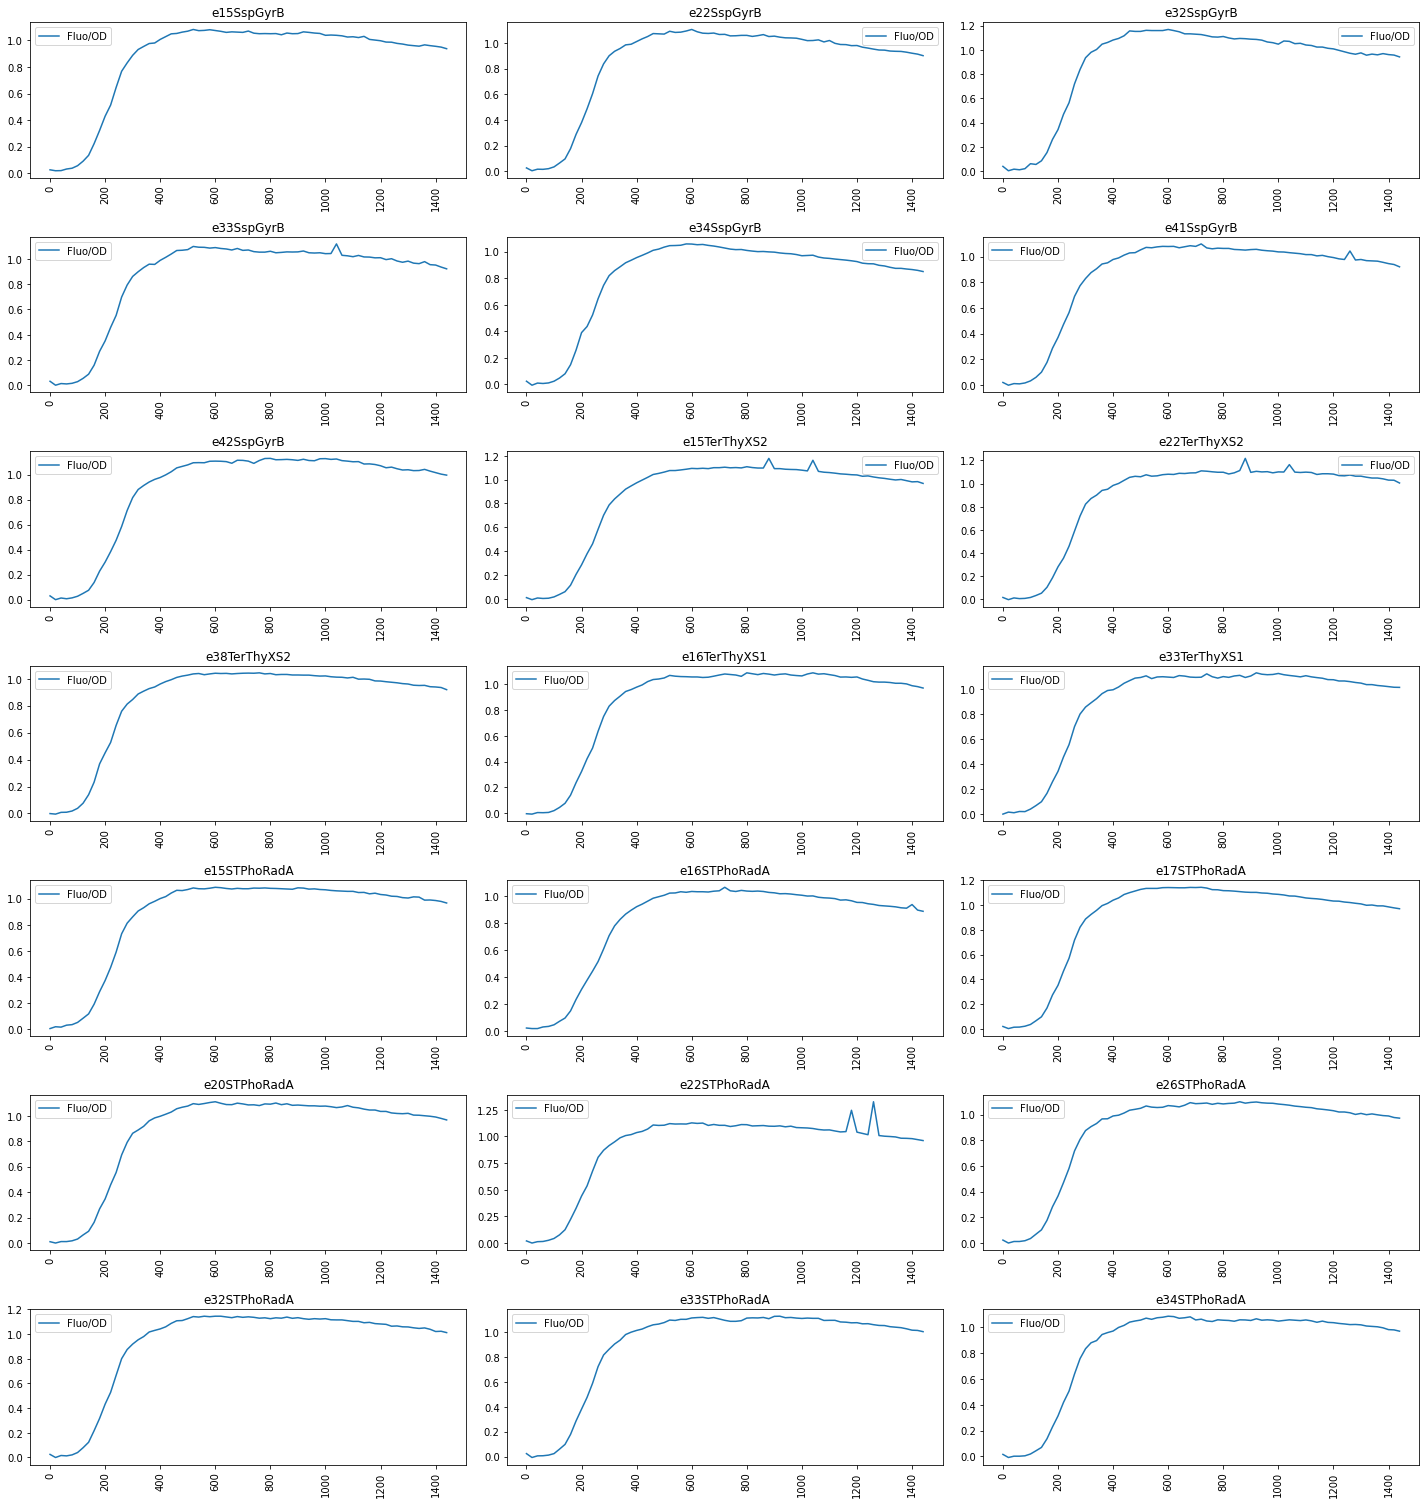

In [8]:
plot_all(od, 7, 3)

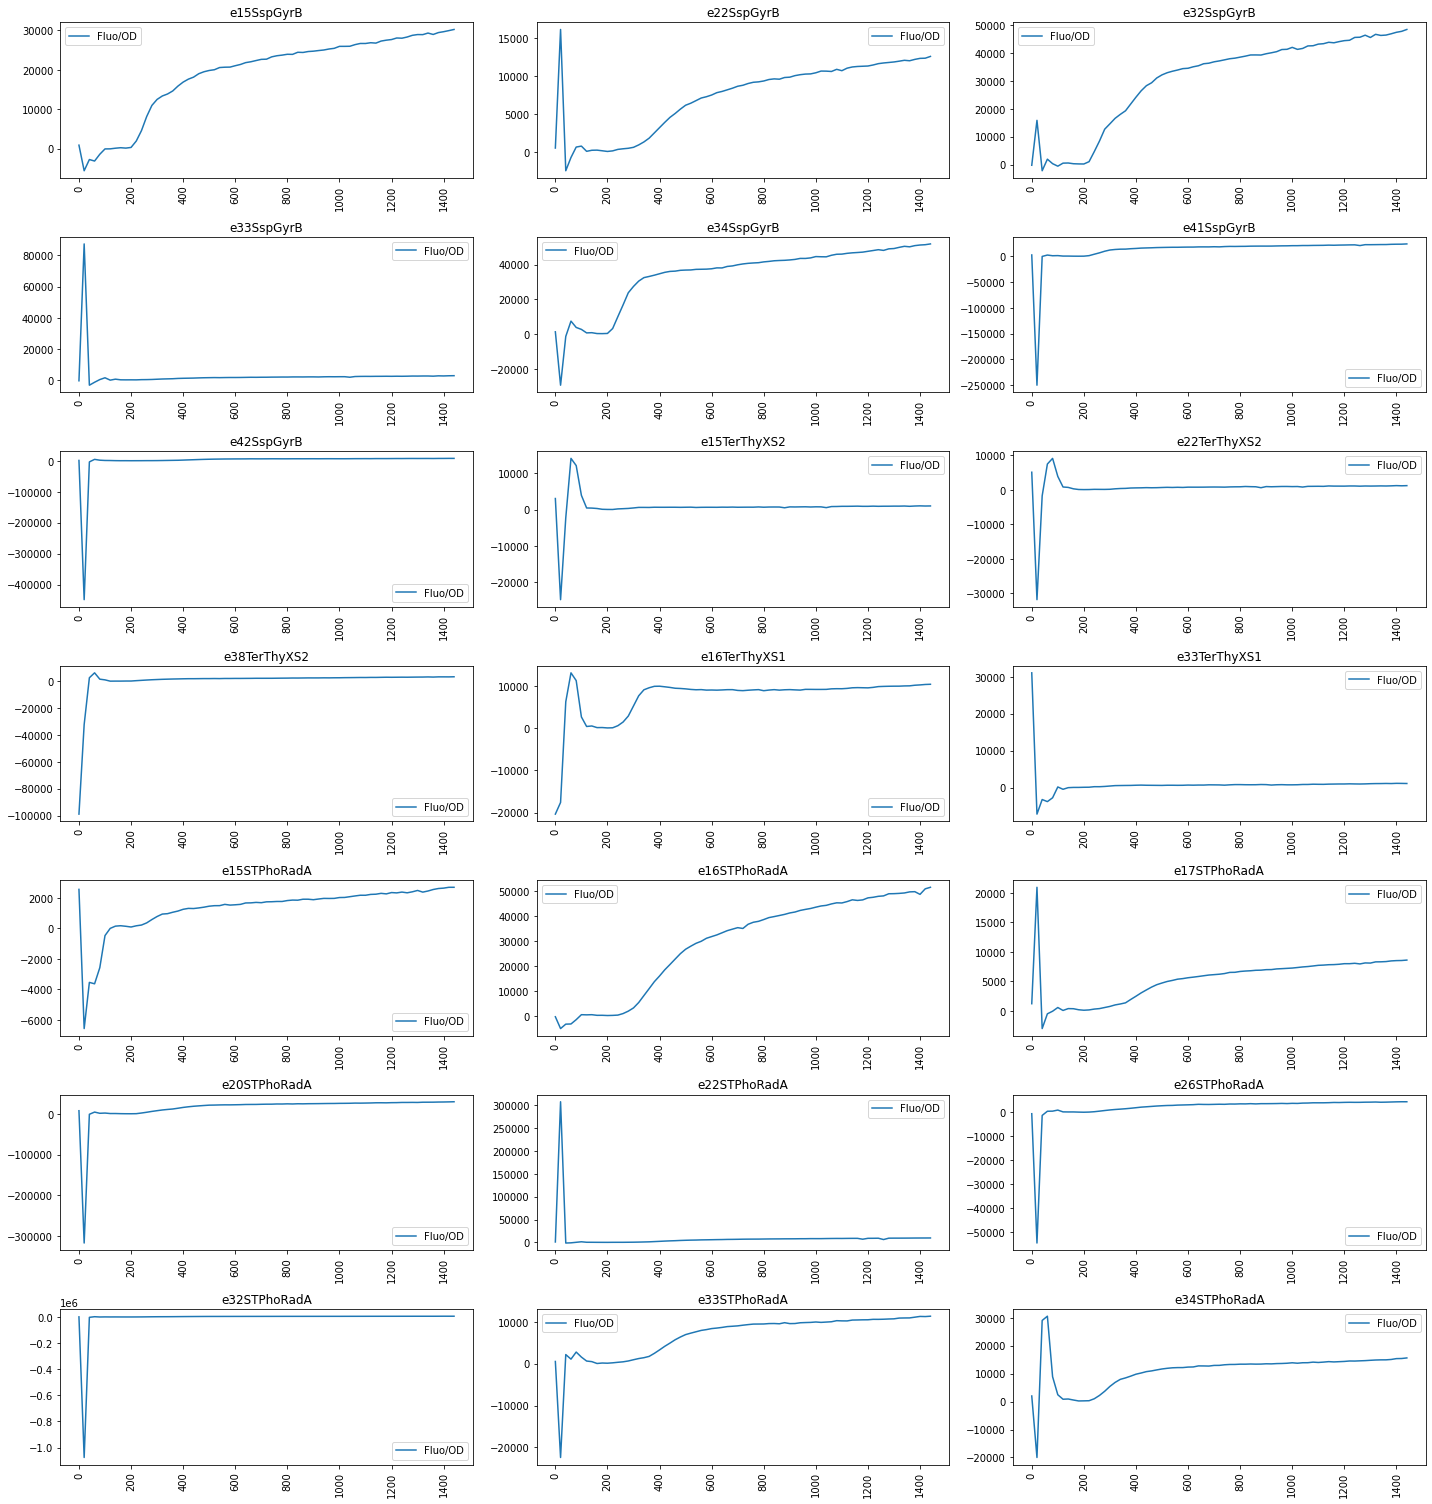

In [7]:
#fluorescence/OD data
fluo_od = pd.read_csv('datasets/fluo-11.csv', index_col=0)
plot_all(fluo_od, 7, 3)

### Modeling

In [27]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def hill_equation(x, K, n):
    return x**n / (K + x**n)

### Functions for 1st level inference (fitting growth data) ###
def od_wrapper(t, k1, k2):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_y0 = np.abs(od_data[0])
    od_rates = (k1, k2)
    od_sol = odeint(od_model, od_y0, t, od_rates)
    return od_sol[:,0]
### END ###

### Functions for 2nd level inference (fitting fluoresence data) ###
def gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, extra, y0):

    def gate_model(y, t):
    
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        #parameters to infer
        syn_ECFn, deg_ECFn, syn_ECFc, deg_ECFc, syn_ECF, deg_ECF, syn_GFP, deg_GFP, kind, n = a, b, c, d, e, f, g, h, i, j
        #fixed parameters
        mgr, mcc = extra
        #differential equations
        dOD = growth_rate(t, OD, mgr, mcc) * OD
        dECFn = syn_ECFn - (deg_ECFn + growth_rate(t, OD, mgr, mcc)) * ECFn
        dECFc = syn_ECFc - (deg_ECFc + growth_rate(t, OD, mgr, mcc)) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg_ECF * ECF)
        dGFP = syn_GFP * hill_equation(ECF, kind, n) - (deg_GFP + growth_rate(t, OD, mgr, mcc)) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#wrapper function to accomodate Scipy's curve_fit
def model_fit(t, a, b, c, d, e, f, g, h, i, j):
    fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, extra, y0)
    return fit[3] #3 for GFP index

### END ###

In [28]:
#objective function
def computeSSE(init_params, data, bounds, col):
    try:
        t = np.arange(len(data))
        params, _ = curve_fit(model_fit, t, data, p0=init_params, bounds=bounds)
        solution = model_wrapper(t, *params, extra, y0)
        error = [(val-sal)**2 for val, sal in zip(solution[col], data)]
    except:
        print('Something wrong')
    
    return sum(error)

#generate random numbers from a uniform distribution for initial guesses
def randomSearch(iterations, num_params, data, bounds, col):
    
    initialGuesses = []
    for k in range(iterations):
        guess = [np.random.uniform(low=0,high=1) for val in range(num_params)]
        error = computeSSE(guess, data, bounds, col)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [107]:
#config
od_bounds = [(0, 0), (1, 1)]
gate_bounds = [[0]*10, [1e5]*10]
num_param = 10 #number of parameters to infer
gfp_col = 3 #index of data to fit
num_iter = 10
selected_index = [0]

def parameter_estimation(fluo, od, selected_index, num_iter, folder_name='inference', write_output=True):

    for idx in selected_index:
        print('======================', idx)

        name = fluo.columns[idx]

        best_params = []
        fig = plt.figure(figsize=(20, 10))
        num_vars = 9
        num_col = 3
        num_row = int(np.ceil(num_vars)/num_col)

        for i in range(num_vars):
            plt.subplot(num_row, num_col, i+1)

            od_data = od[od.columns[idx]]
            od_t = np.arange(0, len(od_data))
            od_params, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)

            fluo_data = fluo[fluo.columns[idx]]
            fluo_t = np.arange(0, len(fluo_data))

            y0 = np.abs([0.0, 0.0, 0.0, fluo_data.iloc[0], od_data.iloc[0]])
            extra = od_params

            try:
                init_guess = randomSearch(num_iter, num_param, fluo_data, gate_bounds, gfp_col)

                try:
                    fluo_params, _ = curve_fit(model_fit, fluo_t, fluo_data, p0=init_guess, bounds=gate_bounds)
                    fit = model_wrapper(fluo_t, *fluo_params, extra, y0)
                    sse = sum([(val-sal)**2 for val,sal in zip(fit[gfp_col], fluo_data)])

                    best_params.append((sse, i, fluo_params))

                    plt.plot(fluo_t, fluo_data, 'x', label='data')
                    plt.plot(fluo_t, fit[gfp_col], '-', label='model')

                    plt.legend()
                    plt.title(str(i) + ' ' + fluo.columns[idx])
                    plt.xlabel(None)
                    print('+++++++++Iteration', i)

                except:
                    print('+++++++++Error in fitting', i)
                    continue

            except:
                print('+++++++++Error in random search', i)
                continue

        plt.tight_layout()
        plt.show()
        fig.savefig('datasets/' + folder_name + '/' + str(cur_col) + '-' + name + '.png')
        
        if write_output:
            
            df = pd.DataFrame([i[2] for i in sorted(best_params)])
            df['index'] = [(str(i[1])+name) for i in sorted(best_params)]
            df = df.set_index('index')
            df = df.transpose()
            df.to_csv('datasets/' + folder_name + '/' + str(cur_col) + '-' + name + '.csv', index=False)
            
#parameter_estimation(fluo, od, selected_index, num_iter)

### Debugging

In [113]:
to_debug = ['e15TerThyXS2', 'e22TerThyXS2', 'e33TerThyXS1']
fluo_debug = fluo[to_debug]
od_debug = od[to_debug]

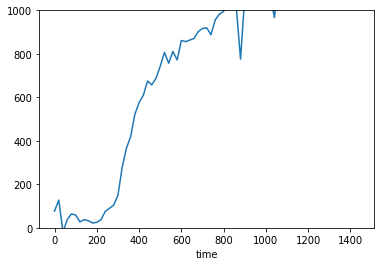

In [127]:
fluo.iloc[:, 8].plot()
plt.ylim(0, 1000)
plt.show()

In [128]:
#smoothing fluoresence data with moving average
for col in fluo_debug.columns.tolist():
    fluo_debug[col] = fluo_debug[col].rolling(window=5).mean()
fluo_debug = fluo_debug.dropna() #just for quick inspection, remove any null

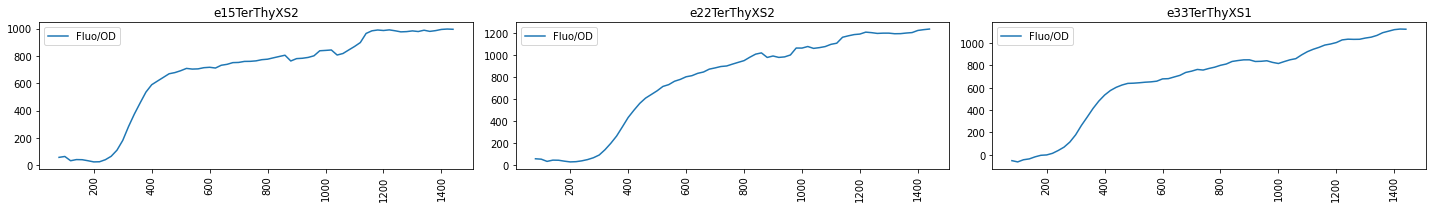

In [129]:
plot_all(fluo_debug, 1, 3)

In [130]:
fluo_debug.isnull().sum()

e15TerThyXS2    0
e22TerThyXS2    0
e33TerThyXS1    0
dtype: int64

In [137]:
fluo_debug = fluo_debug[5:]

====================== 1
+++++++++Iteration 0
+++++++++Iteration 1
+++++++++Iteration 2
+++++++++Iteration 3
+++++++++Error in random search 4
+++++++++Iteration 5
+++++++++Iteration 6
+++++++++Iteration 7
+++++++++Iteration 8


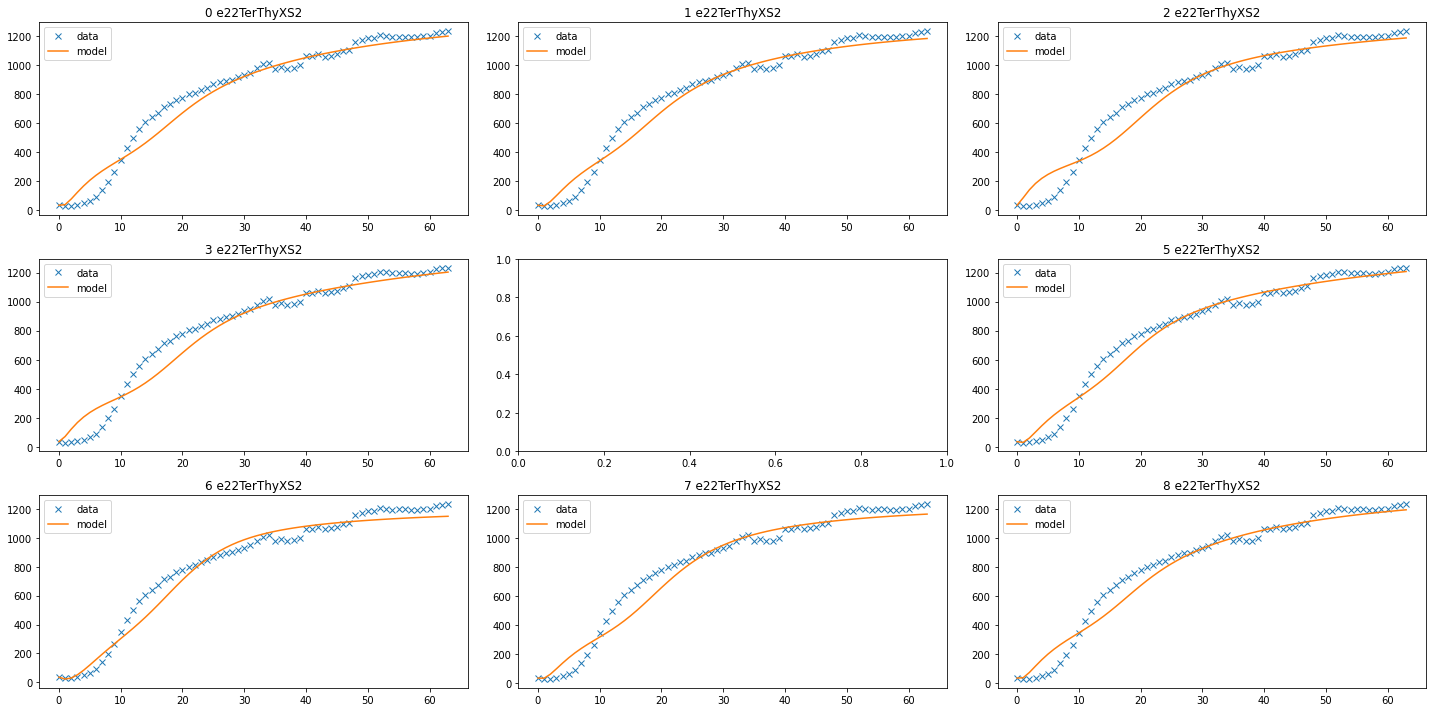

In [138]:
index = [1]
num_iter = 25
parameter_estimation(fluo_debug, od_debug, index, num_iter)